# Machine Learning Authorship Attribution with Poetry


## 1. Project Topic and Description

### Introduction
   
Often, manuscripts of a certain author might be found without certain authorship established. Therefore, authorship classification based on previous works is often useful. Human experts in textual studies or in the literature of  particular author  propose arguments for and against authorship in cases of unattributed works. In a famous case, *The Federalist Papers*, certain documents were written by several authors under one name, and the question of each essay's authorship has been popular in authorship attribution.

Emily Dickinson was a poet whose work was published almost entirely posthumously. What's more, her poems were originally published with some of her most salient features edited out - eccentric use of punctuation and capitalization. That is to say, although Dickinson's poems do now have established authorship, it is easy to conceive of a situation with manuscripts of these poems in which in-depth authorship analysis might have been necessary.

In this project I will do Natural Language Processing on poems in order to classify whether they were written by Emily Dickinson or not. 

That is, I will classify poems as either
   - by Emily Dickinson, or
   - not by Emily Dickinson

To be clear, this is a contrived problem. At the moment, there are no outstanding controversies or ambiguities about the authorship of any poems attributed to Dickinson. Nonethless, it is an exercise that could be useful in a plausibly real situation of a found manuscript without certain authorship.

**NLP Problem**: Binary classification of poems based on authorship

**NLP solution**: Use document vectors as features for machine learning binary classification

I will use a text file containing 356 of her poems, and then sample 356 poems from a dataset of other poets to get a balanced dataset for training.
   - https://www.kaggle.com/jenlooper/emily-dickinson-poetry
   - https://www.kaggle.com/johnhallman/complete-poetryfoundationorg-dataset

In [1]:
import csv
import nltk
%matplotlib inline
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

In [2]:
# seed for methods with randomized elements

# Emily Dickinson's birthday is 12/10/1830
seed = 12101830

## 2. Data Collection / Organization (Text Dataset)

I will use two datasets, combined into one set for machine learning:
   - One of 356 poems all by Emily Dickinson
   - A dataset of over 15k poems from the Poetry Foundation. I will sample 356 of these poems to create a balanced set to learn with.

### Emily Dickinson poems

In [3]:
with open('emily_dickinson_titleless.txt', 'r', encoding="utf8") as fin:
    poems = fin.read()

poems = poems.split("\n\n\n")
print(f"{len(poems)} Emily Dickinson poems loaded\n")

print("Sample poem:\n")
print(poems[2])

356 Emily Dickinson poems loaded

Sample poem:

The Life we have is very great.
The Life that we shall see
"Surpasses it, we know, because"
It is Infinity.
But when all Space has been beheld
And all Dominion shown
The smallest Human Heart's extent
Reduces it to none.


In [4]:
emily = pd.DataFrame(poems)
# target column defined as "emily" - ie a poem by Emily Dickinson
emily["emily"] = 1
emily.rename(columns={0:'poem'}, inplace=True)

### Other Poets' poems

In [5]:
# reading in the Poetry Foundation dataset as a Pandas dataframe
df = pd.read_csv('kaggle_poem_dataset.csv')

In [6]:
# dropping Dickinson from this set, because I only want other poets
df_notemily = df[df.Author!="Emily Dickinson"]

I'll only take poems from poets in the top 100 in terms of number of poems in the dataset

In [7]:
# list comprehension finding the top 100 poets in terms of number of poems
top100=[poet for poet in df_notemily.groupby('Author').Title.count().sort_values(ascending = False)[:100].keys()]

# filtering the whole dataframe to keep only rows by authors in the top 100
df_top100 = df_notemily[df_notemily.Author.isin(top100)]
df_top100 = pd.DataFrame(df_top100)

df_top100["emily"] = 0  # setting the target as 0, ie, not by Emily Dickinson

# dropping the other columns
df_top100.drop(['Author','Title','Poetry Foundation ID', 'Unnamed: 0'], axis=1, inplace=True) 
#making column names consistent with other df
df_top100.rename(columns={"Content":"poem"}, inplace = True) 

### Final Set to Start Feature Extraction - Balanced Targets

In [8]:
# taking a random sample of poems from the top 100 other poets. 
# 356 to make a balanced dataset with the number of Dickinson poems in the Dickinson set
df_otherpoets = df_top100.sample(n=356, random_state=seed)

In [9]:
# putting them both together
poetry = pd.concat([emily, df_otherpoets])
poetry = poetry.reset_index().drop(columns=["index"])

poetry

,poem,emily
0,Not at Home to Callers\nSays the Naked Tree --...,1
1,Which is the best -- the Moon or the Crescent?...,1
2,The Life we have is very great.\nThe Life that...,1
3,Her Sweet turn to leave the Homestead\nCame th...,1
4,We should not mind so small a flower --\nExcep...,1
...,...,...
707,So they stood\nUpon ladders\nWith pruning hook...,0
708,Everything contains some\nsilence. Noise gets\...,0
709,"Having been tenant long to a rich lord,\nNot t...",0
710,Sitteth alle stille and herkneth to me!\nThe K...,0


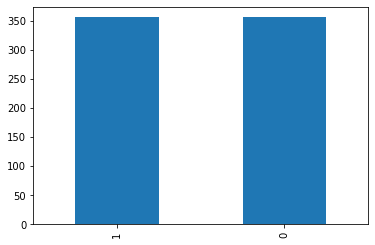

In [10]:
poetry.emily.value_counts().plot(kind = 'bar');

From the small sample of the dataset and the bar chart of target values, we see what sort of dataset we have. We have 356 poems by Emily Dickinson (with value of 1 for the column `emily`) and 356 poems randomly sampled from other poets in the Poetry Foundation Dataset (with value of 0 for the column `emily`). 

We can extract features from the texts of the poems to use in machine learning, and then fit a model to classify a poem as 1 (by Emily Dickinson) or 0 (not by Emily Dickinson). 

## 3. Model Development and Selection

In [11]:
# Creating two meta-data columns based on number of stanzas and number of lines in each poem

# counting the number of stanzas in each poem with regular expression
pat_stanza = re.compile(r"\n\n")
poetry["stanzas"] = poetry.poem.apply(lambda x: len(re.findall(pat_stanza, x))+1)

# counting the number of lines in each poem with regular expression
pat_line = re.compile(r"\n\n|\n")
poetry["lines"] = poetry.poem.apply(lambda x: len(re.findall(pat_line, x))+1)

### Gensim Model Trained on Poetry Foundation Dataset

In [12]:
%%time
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# training the model with the normal poetry text dataset
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df.Content)]
model1 = Doc2Vec(documents, vector_size=300, window=2, min_count=2, seed=seed)

CPU times: user 2min 58s, sys: 3.64 s, total: 3min 1s
Wall time: 1min 13s


In [13]:
# removing the double dash "--" and capitalization from all text to avoid over-training on Dickinson
# this double dash and unique capitalization are very salient features of her work

def tokenize_nodash(text):
    terms = nltk.word_tokenize(text)
    terms = [word.lower() for word in terms if word != '--']
    return terms

In [14]:
# using the model trained on Poetry Foundation poems to get document vectors from the dataset
vecs_found = poetry.poem.map(lambda x: model1.infer_vector(tokenize_nodash(x))) #poetry foundation
vecs_found = pd.DataFrame(vecs_found.to_list())

In [15]:
#combining Document vector features with the 2 meta data features
X_found = np.column_stack((np.asarray(vecs_found), np.asarray(poetry[['lines', 'stanzas']])))

### GridSearch for Model Selection
#### Support Vector Machine

In [16]:
%%time
# SVC Gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC(random_state=seed)


param_grid = {'kernel': ['rbf','linear'],
              'C': [1, 10, 100, 500],
              'gamma' : ['scale', 'auto']}

# Set up search
searchSVC1 = GridSearchCV(estimator=svc,
              param_grid=param_grid,
              scoring='accuracy',
              cv=10,
              n_jobs=2)
searchSVC2 = GridSearchCV(estimator=svc,
              param_grid=param_grid,
              scoring='accuracy',
              cv=10,
              n_jobs=2)
# Run search
search_svc_found_meta = searchSVC1.fit(X_found, poetry.emily.values)
search_svc_found_nometa = searchSVC2.fit(vecs_found.values, poetry.emily.values)

# output search results
print("\nSVC Search Results - Poetry Foundation Vectors with Meta Data")
print(search_svc_found_meta.best_score_)
print(search_svc_found_meta.best_params_)

print("\nSVC Search Results - Poetry Foundation Vectors without Meta Data")
print(search_svc_found_nometa.best_score_)
print(search_svc_found_nometa.best_params_)

print('\n')


SVC Search Results - Poetry Foundation Vectors with Meta Data
0.943798904538341
{'C': 500, 'gamma': 'auto', 'kernel': 'rbf'}

SVC Search Results - Poetry Foundation Vectors without Meta Data
0.9367566510172143
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


CPU times: user 419 ms, sys: 105 ms, total: 524 ms
Wall time: 2min 22s


#### Random Forest

In [17]:
%%time
# Random Forest Gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=seed)

param_grid = {'n_estimators': [100,300,500],
              'max_depth': [4,6,10,15]}

# Set up search
searchrf1 = GridSearchCV(estimator=rf,
              param_grid=param_grid,
              scoring='accuracy',
              cv=10,
              n_jobs=2)
searchrf2 = GridSearchCV(estimator=rf,
              param_grid=param_grid,
              scoring='accuracy',
              cv=10,
              n_jobs=2)

# Run search
search_rf_found_meta = searchrf1.fit(X_found, poetry.emily.values)
search_rf_found_nometa = searchrf2.fit(vecs_found.values, poetry.emily.values)

# output search results
print("\nRandom Forest Search Results - Poetry Foundation Vectors with Meta Data")
print(search_rf_found_meta.best_score_)
print(search_rf_found_meta.best_params_)

print("\nRandom Forest Search Results - Poetry Foundation Vectors without Meta Data")
print(search_rf_found_nometa.best_score_)
print(search_rf_found_nometa.best_params_)

print('\n')


Random Forest Search Results - Poetry Foundation Vectors with Meta Data
0.9353677621283255
{'max_depth': 6, 'n_estimators': 500}

Random Forest Search Results - Poetry Foundation Vectors without Meta Data
0.9381846635367763
{'max_depth': 4, 'n_estimators': 100}


CPU times: user 3.13 s, sys: 127 ms, total: 3.26 s
Wall time: 2min 50s


#### Model Selection

In the above, I searched multiple hyperparameters across a variety of model possibilities with cross validation, trying combinations of:
   - Random Forest classifier
   - Support Vector Machine classifier
   - with meta data columns (number of stanzas and number of lines)
   - without meta data columns

The best model was a Support Vector Machine:
   - Document vectors trained on Poetry foundation poems dataset
   - with meta data
   - Support Vector Machine
      - Kernel: RBF
      - C: 500
      - Gamma: auto

In [18]:
final_model = SVC(kernel = 'rbf',
                  C=500,
                  gamma = 'auto',
                  random_state=seed)

## 4. Model Evaluation

I will now implement the best model on a final 80/20 train/test split on the dataset. 

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_found, poetry.emily,
                                     test_size=0.20,
                                     stratify=poetry.emily,
                                     random_state=seed)

final_model.fit(X_train,y_train)
preds = final_model.predict(X_test)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        72
           1       0.92      0.97      0.95        71

    accuracy                           0.94       143
   macro avg       0.95      0.94      0.94       143
weighted avg       0.95      0.94      0.94       143



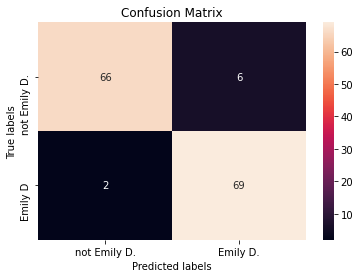

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt 

cm = confusion_matrix(y_test, preds)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); #annot=True to annotate cells,ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not Emily D.', 'Emily D.']); ax.yaxis.set_ticklabels(['not Emily D.', 'Emily D']);

# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

## 5. Conclusions

In this project I used document vectors as machine learning features to classify poems by binary authorship. I achieved an accuracy rate of 94%. In the testing, 
   - Only 2 out of 71 poems actually by Emily Dickinson were incorrectly classifed. 
   - 6 out of 72 poems by other authors were incorrectly  classified as by her. 
   
This demonstrated an effective outline for a method to use supervised machine learning to determine poetry authorship. 

Future work could further develop this outline by attempting other methods to improve accuracy, like averaged word vectors from massive corpora, neural networks for classification, or features from state-of-the-art sentence transformers instead of Doc2Vec document vectors. Moreover, further work could expand the problem question to address authorship for several poets at once.